In [1]:
# @title install
!pip install bitsandbytes
!pip install openai
!pip install tqdm
!pip install bitsandbytes accelerate
!pip install geomloss
!!rm -rf ~/.cache/huggingface/hub

[]

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!nvidia-smi
import torch
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Sun Aug  3 13:24:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, BitsAndBytesConfig
import bitsandbytes as bnb
import math
from tqdm import tqdm
from peft import prepare_model_for_kbit_training

# ---- 1. Configuration ----
generate_id = "baichuan-inc/Baichuan2-7B-Chat"
eval_id = "01-ai/Yi-6B"
MAX_NEW_TOKENS = 80
CHUNK_TOKENS = 32
TAU = 0.5
KV_KEEP_LAST = 256

In [5]:
# ---- 2. 模型设置 ----

# 配置 BitsAndBytes 的 4bit 量化设置，用于节省显存
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                   # 启用 4bit 加载
    bnb_4bit_quant_type="nf4",          # 使用 nf4 量化类型（相较于fp4保留更多信息）
    bnb_4bit_use_double_quant=True,     # 启用双重量化，进一步减小模型大小
    bnb_4bit_compute_dtype=torch.bfloat16  # 在 bfloat16 精度下计算，提高效率
)

# 加载生成模型的 tokenizer
generate_tokenizer = AutoTokenizer.from_pretrained(generate_id, trust_remote_code=True)

# 加载生成模型并应用 4bit 量化配置，自动分配到可用设备
generate_model = AutoModelForCausalLM.from_pretrained(
    generate_id,
    quantization_config=bnb_config,
    device_map="auto",                  # 自动将模型分配到 CPU/GPU（支持多卡）
    trust_remote_code=True,              # 允许使用模型仓库中自定义的代码
    force_download=True                 # 强制下载模型
)

# --- 关键修复：显式禁用梯度检查点（gradient checkpointing） ---
# 防止与 use_cache=True 冲突，确保 KV cache 正常工作（生成速度更快）
generate_model = prepare_model_for_kbit_training(
    generate_model, use_gradient_checkpointing=False
)

# 加载评估模型的 tokenizer
eval_tokenizer = AutoTokenizer.from_pretrained(eval_id, trust_remote_code=True)

# 加载评估模型（非生成模型），使用 bfloat16 精度并转到指定设备
eval_model = AutoModel.from_pretrained(
    eval_id, torch_dtype=torch.bfloat16, trust_remote_code=True
).to(device).eval()  # 设置为 eval 模式，避免更新权重

# 冻结评估模型参数，防止在训练中被更新
for p in eval_model.parameters():
    p.requires_grad = False

# 获取生成模型所在的设备（用于后续保持一致）
device = next(generate_model.parameters()).device


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/795 [00:00<?, ?B/s]

tokenization_baichuan.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/baichuan-inc/Baichuan2-7B-Chat:
- tokenization_baichuan.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer.model:   0%|          | 0.00/2.00M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

configuration_baichuan.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/baichuan-inc/Baichuan2-7B-Chat:
- configuration_baichuan.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

modeling_baichuan.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/baichuan-inc/Baichuan2-7B-Chat:
- modeling_baichuan.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
pip install xformers.


pytorch_model.bin:   0%|          | 0.00/15.0G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.18G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
print(type(generate_model.model.layers[0].self_attn.W_pack.weight))


<class 'bitsandbytes.nn.modules.Params4bit'>


In [7]:
from tqdm import tqdm, trange
import random
import torch.nn.functional as F
import math
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
# ---- 3. 桥接层和优化器设置 ----

# 获取生成模型的输入嵌入层权重（即 token embedding 矩阵）
E_gen = generate_model.get_input_embeddings().weight

# 生成模型 embedding 的维度（如 4096）
d_g = E_gen.size(1)

# 评估模型 embedding 的维度（如 1024）
d_e = eval_model.get_input_embeddings().embedding_dim

# 获取评估模型嵌入层使用的数据类型（通常是 bfloat16）
eval_dtype = eval_model.get_input_embeddings().weight.dtype

# 尝试从生成模型中读取已有的“桥接层”属性（避免重复创建）
try:
    bridge_E = generate_model._embed_bridge
except AttributeError:
    # 如果没有现成的桥接层，则新建一个从 d_b → d_y 的线性层（无偏置）
    bridge_E = nn.Linear(d_g, d_e, bias=False)
    # 把这个桥接层挂载到生成模型上（作为一个临时成员变量）
    generate_model._embed_bridge = bridge_E

# 把桥接层移动到对应设备，并设置为评估模型的 dtype（如 bfloat16）
bridge_E = bridge_E.to(device=device, dtype=eval_dtype)

# 启用桥接层的梯度（让其参与训练）
for p in bridge_E.parameters():
    p.requires_grad = True






In [8]:
# @title kv-cache
# 剪裁 KV 缓存长度，避免无限增长导致显存爆炸
def trim_past_key_values(past, keep_last: int):
    if past is None or keep_last is None:
        return past
    trimmed = []
    for k, v in past:
        k = k[..., -keep_last:, :].contiguous()
        v = v[..., -keep_last:, :].contiguous()
        trimmed.append((k, v))
    return tuple(trimmed)

In [9]:
# @title get_rep_loss
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def get_rep_loss(
    poem_vecs: dict[int, torch.Tensor],
    good_poems_vecs: dict[int, torch.Tensor],
    top_p: float = 0.1,
    layer: int = 31,
    plot: bool = True
) -> torch.Tensor:
    """
    计算重复率损失：对每首生成诗，与好诗计算余弦相似度，选取 Top-P% 最大值求平均。
    越高表示重复越严重。

    Args:
        poem_vecs (dict[int, Tensor]): 当前生成诗的向量表示
        good_poems_vecs (dict[int, Tensor]): 好诗的向量表示
        top_p (float): 百分比 (0~1)，表示每首诗保留相似度前 top_p 的部分
        layer (int): 使用的层号
        plot (bool): 是否绘制相似度直方图

    Returns:
        Tensor: 平均 top-p 相似度，作为重复率损失
    """
    if layer not in poem_vecs or layer not in good_poems_vecs:
        raise ValueError(f"Layer {layer} not found in input vectors.")

    vec_gen = F.normalize(poem_vecs[layer].clone(), dim=-1)       # [B, D]
    vec_good = F.normalize(good_poems_vecs[layer].clone(), dim=-1)  # [N, D]

    sim_matrix = torch.matmul(vec_gen, vec_good.T)  # [B, N]
    B, N = sim_matrix.shape

    # 动态计算 k based on percentage
    k = max(1, int(N * top_p))  # 至少为1
    topk_values, _ = torch.topk(sim_matrix, k=k, dim=1)  # [B, k]
    loss = topk_values.mean()

    # 可视化相似度分布
    if plot:
        with torch.no_grad():
            sims_np = sim_matrix.flatten().cpu().numpy()
            plt.figure(figsize=(8, 5))
            plt.hist(sims_np, bins=50, color='skyblue', edgecolor='black')
            plt.title(f"Cosine Similarity Histogram (Layer {layer}, Top-{int(top_p*100)}%)")
            plt.xlabel("Cosine Similarity")
            plt.ylabel("Frequency")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    return loss


In [10]:
# @title get_quality_loss
import torch
import torch.nn.functional as F
from geomloss import SamplesLoss
import matplotlib.pyplot as plt

def get_quality_score(
    poem_vecs: dict[int, torch.Tensor],
    good_poems_vecs: dict[int, torch.Tensor],
    blur: float = 0.05,
    alpha: float = 0.5,
    plot: bool = True
) -> torch.Tensor:
    """
    计算生成诗与好诗在多个层上的 Sinkhorn 距离（单位化后），
    并对第 25 和 31 层的结果进行加权平均，作为最终质量损失。

    Args:
        poem_vecs (dict[int, Tensor]): 每层的生成诗向量
        good_poems_vecs (dict[int, Tensor]): 每层的好诗向量
        blur (float): Sinkhorn 距离的模糊参数
        alpha (float): 第 31 层与第 25 层的加权比例（默认 0.5）
        plot (bool): 是否可视化每层 Sinkhorn 距离

    Returns:
        Tensor: 加权后的质量损失
    """
    assert 25 in poem_vecs and 31 in poem_vecs, "缺少第 25 或 31 层的向量"

    loss_fn = SamplesLoss("sinkhorn", p=2, blur=blur)
    layer_losses = {}

    for layer in range(25, 33):
        if layer not in poem_vecs or layer not in good_poems_vecs:
            raise ValueError(f"Layer {layer} missing in inputs.")

        vec_gen = F.normalize(poem_vecs[layer].clone(), dim=-1)
        vec_good = F.normalize(good_poems_vecs[layer].clone(), dim=-1)
        layer_losses[layer] = loss_fn(vec_gen, vec_good)

    if plot:
        plt.figure(figsize=(8, 5))
        plt.bar(
            [f"Layer {i}" for i in range(25, 33)],
            [layer_losses[i].item() for i in range(25, 33)],
            color="skyblue"
        )
        plt.axvline(x=0, color="orange", linestyle="--", label="Used in Loss (25)")
        plt.axvline(x=6, color="green", linestyle="--", label="Used in Loss (31)")
        plt.title("Sinkhorn Distance per Layer (Normalized)")
        plt.ylabel("Sinkhorn Distance")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    total_loss = alpha * layer_losses[31] + (1 - alpha) * layer_losses[25]
    return total_loss


In [11]:
# @title get_diversity_loss
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def get_diversity_loss(
    poem_vecs: dict[int, torch.Tensor],
    layer: int = 31,
    plot: bool = True
) -> torch.Tensor:
    """
    计算生成诗歌在多个层的多样性（平均余弦相似度），
    并返回指定层的值作为损失。

    Args:
        poem_vecs (dict[int, Tensor]): 每层的生成诗表示
        layer (int): 要返回的目标层
        plot (bool): 是否可视化所有层的 diversity 分布

    Returns:
        Tensor: 指定层的平均余弦相似度（越高越不多样）
    """
    layer_losses = {}

    for lyr in range(25, 33):
        vec_gen = F.normalize(poem_vecs[lyr].clone(), dim=-1)  # [B, D]

        sim_matrix = torch.matmul(vec_gen, vec_gen.T)  # [B, B]
        B = sim_matrix.size(0)
        mask = torch.triu(torch.ones(B, B, device=vec_gen.device), diagonal=1).bool()
        selected_sims = sim_matrix[mask]

        if selected_sims.numel() == 0:
            loss = torch.tensor(0.0, device=vec_gen.device, requires_grad=True)
        else:
            loss = selected_sims.mean()

        layer_losses[lyr] = loss

    if plot:
        layers = list(layer_losses.keys())
        values = [layer_losses[l].detach().cpu().item() for l in layers]
        plt.figure(figsize=(8, 5))
        plt.plot(layers, values, marker="o", linestyle="-", color="green")
        plt.title("Diversity (Avg Cosine Similarity) per Layer")
        plt.xlabel("Layer")
        plt.ylabel("Avg Cosine Similarity (Lower = More Diverse)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return layer_losses[layer]


In [12]:
# @title load good_poem_vecs
# 加载好诗向量并放到相同设备
good_poem_vecs = torch.load("/content/drive/MyDrive/good_poems_vecs.pt")
good_poem_vecs = {layer: good_poem_vecs[layer].to(device) for layer in range(25, 33)}

In [13]:
# @title evaluate_on_val_set
def evaluate_on_val_set(
    val_theme_ids, label_to_theme, good_poems_vecs, W,
    generate_model, eval_model, bridge_E,
    GROUP_SIZE=10, MAX_NEW_TOKENS=80, CHUNK_TOKENS=32,
    TAU=0.5, KV_KEEP_LAST=256, E_gen=None, eval_dtype=torch.float32, device="cuda"
):
    generate_model.eval()
    val_vecs_tmp = []

    theme_idx = random.choice(val_theme_ids)
    val_prompt = f"你是一位唐代诗人，擅长写唐诗。请原创一首{label_to_theme[theme_idx]}主题的唐诗，每一句五或七个字，共四句，只输出四句正文，不输出题目。"

    with torch.no_grad():
        for _ in range(GROUP_SIZE):
            enc = generate_tokenizer(val_prompt, return_tensors="pt").to(device)
            out = generate_model(input_ids=enc["input_ids"], use_cache=True)
            past_key_values = out.past_key_values

            cur_gen_embeds = generate_model.get_input_embeddings()(enc["input_ids"][:, -1:])
            chunk_eval_soft_embeds = []

            num_chunks = math.ceil(MAX_NEW_TOKENS / CHUNK_TOKENS)
            for ci in range(num_chunks):
                steps_this_chunk = min(CHUNK_TOKENS, MAX_NEW_TOKENS - ci * CHUNK_TOKENS)
                for _ in range(steps_this_chunk):
                    out = generate_model(
                        inputs_embeds=cur_gen_embeds,
                        past_key_values=past_key_values,
                        use_cache=True
                    )
                    logits = out.logits[:, -1, :]
                    past_key_values = out.past_key_values
                    past_key_values = tuple((k.detach(), v.detach()) for k, v in past_key_values)

                    y_soft = F.gumbel_softmax(logits, tau=TAU, hard=False, dim=-1).unsqueeze(1)
                    next_gen_embed = y_soft.to(E_gen.dtype) @ E_gen
                    cur_gen_embeds = next_gen_embed

                    next_eval_embed = bridge_E(next_gen_embed.to(dtype=eval_dtype))
                    chunk_eval_soft_embeds.append(next_eval_embed)

            eval_inputs = torch.cat(chunk_eval_soft_embeds, dim=1)
            out_eval = eval_model(inputs_embeds=eval_inputs, output_hidden_states=True)

            poem_vec = {layer: out_eval.hidden_states[layer].float().mean(dim=1) for layer in range(25, 33)}
            val_vecs_tmp.append(poem_vec)

        group_poem_vecs = {layer: torch.cat([d[layer] for d in val_vecs_tmp], dim=0) for layer in range(25, 33)}

        rep_loss = get_rep_loss(poem_vecs=group_poem_vecs, good_poems_vecs=good_poems_vecs, top_p=0.1, layer=31, plot=False)
        quality_loss = get_quality_score(poem_vecs=group_poem_vecs, good_poems_vecs=good_poems_vecs, blur=0.05, alpha=0.5, plot=False)
        diversity_loss = get_diversity_loss(poem_vecs=group_poem_vecs, layer=31, plot=False)

        total_val_loss = W[0] * rep_loss + W[1] * quality_loss + W[2] * diversity_loss
        return total_val_loss.item()



In [14]:
# @title train_one_epoch
def train_one_epoch(
    epoch, theme_idx, label_to_theme, good_poem_vecs, val_theme_ids, W,
    generate_model, eval_model, bridge_E, optimizer,optim_params,
    GROUP_SIZE=10, MAX_NEW_TOKENS=80, CHUNK_TOKENS=32, TAU=0.5, KV_KEEP_LAST=256,
    E_gen=None, eval_dtype=torch.float32, device="cuda",
    GRAD_ACCUM_STEPS=4, MAX_GRAD_NORM=1.0
):
    generate_model.train()
    optimizer.zero_grad(set_to_none=True)
    group_poem_vecs_tmp = []
    num_chunks = math.ceil(MAX_NEW_TOKENS / CHUNK_TOKENS)

    train_prompt = f"你是一位唐代诗人，擅长写唐诗。请原创一首{label_to_theme[theme_idx]}主题的唐诗，每一句五或七个字，共四句，只输出四句正文，不输出题目。"

    for gi in range(GROUP_SIZE):
        enc = generate_tokenizer(train_prompt, return_tensors="pt").to(device)
        with torch.no_grad():
            init_out = generate_model(input_ids=enc["input_ids"], use_cache=True)
            past_key_values = init_out.past_key_values

        cur_gen_embeds = generate_model.get_input_embeddings()(enc["input_ids"][:, -1:])
        chunk_eval_soft_embeds = []

        for ci in range(num_chunks):
            steps_this_chunk = min(CHUNK_TOKENS, MAX_NEW_TOKENS - ci * CHUNK_TOKENS)
            for _ in range(steps_this_chunk):
                out = generate_model(
                    inputs_embeds=cur_gen_embeds,
                    past_key_values=past_key_values,
                    use_cache=True
                )
                logits = out.logits[:, -1, :]
                past_key_values = out.past_key_values
                past_key_values = trim_past_key_values(past_key_values, keep_last=KV_KEEP_LAST)
                past_key_values = tuple((k.detach(), v.detach()) for k, v in past_key_values)

                y_soft = F.gumbel_softmax(logits, tau=TAU, hard=False, dim=-1).unsqueeze(1)
                next_gen_embed = y_soft.to(E_gen.dtype) @ E_gen
                cur_gen_embeds = next_gen_embed

                next_eval_embed = bridge_E(next_gen_embed.to(dtype=eval_dtype))
                chunk_eval_soft_embeds.append(next_eval_embed)

        eval_inputs = torch.cat(chunk_eval_soft_embeds, dim=1)
        out_eval = eval_model(inputs_embeds=eval_inputs, output_hidden_states=True)

        poem_vec = {layer: out_eval.hidden_states[layer].float().mean(dim=1) for layer in range(25, 33)}
        group_poem_vecs_tmp.append(poem_vec)

        # 梯度累积：每 gi 执行一次 loss.backward
        if (gi + 1) % GRAD_ACCUM_STEPS == 0 or (gi + 1) == GROUP_SIZE:
            group_poem_vecs = {
                layer: torch.cat([poem[layer] for poem in group_poem_vecs_tmp], dim=0)
                for layer in range(25, 33)
            }

            rep_loss = get_rep_loss(poem_vecs=group_poem_vecs, good_poems_vecs=good_poem_vecs, top_p=0.1, layer=31, plot=False)
            quality_loss = get_quality_score(poem_vecs=group_poem_vecs, good_poems_vecs=good_poem_vecs, blur=0.05, alpha=0.5, plot=False)
            diversity_loss = get_diversity_loss(poem_vecs=group_poem_vecs, layer=31, plot=False)
            loss = W[0] * rep_loss + W[1] * quality_loss + W[2] * diversity_loss

            # 梯度累积分摊
            (loss / GRAD_ACCUM_STEPS).backward()

            # 梯度裁剪 + 参数更新
            torch.nn.utils.clip_grad_norm_(optim_params, MAX_GRAD_NORM)
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            # 清空临时缓存
            group_poem_vecs_tmp.clear()

    # 验证集评估
    val_loss = evaluate_on_val_set(
        val_theme_ids, label_to_theme, good_poem_vecs, W,
        generate_model, eval_model, bridge_E,
        GROUP_SIZE=GROUP_SIZE, MAX_NEW_TOKENS=MAX_NEW_TOKENS, CHUNK_TOKENS=CHUNK_TOKENS,
        TAU=TAU, KV_KEEP_LAST=KV_KEEP_LAST,
        E_gen=E_gen, eval_dtype=eval_dtype, device=device
    )

    lr = optimizer.param_groups[0]['lr']
    print(f"\nEpoch {epoch} finished:")
    print(f"rep_loss = {rep_loss.item():.4f}, quality_loss = {quality_loss.item():.4f}, "
          f"diversity_loss = {diversity_loss.item():.4f}, val_loss = {val_loss:.4f}, "
          f"total_loss = {loss.item():.4f}, lr = {lr:.2e}")

    return {
        "epoch": epoch,
        "theme_idx": theme_idx,
        "rep_loss": rep_loss.item(),
        "quality_loss": quality_loss.item(),
        "diversity_loss": diversity_loss.item(),
        "total_loss": loss.item(),
        "val_loss": val_loss,
        "lr": lr,
        "theme_idx": theme_idx
    }


In [15]:
# 原始主题列表
label_to_theme = {
    0: "爱情",
    1: "送别",
    2: "思乡",
    3: "田园",
    4: "边塞",
    5: "咏史怀古",
    6: "咏物"
}


# 明确划分
train_theme_ids = [0, 1, 2, 3, 4, 5, 6]
val_theme_ids = [0, 1, 2, 3, 4, 5, 6]


In [16]:
GROUP_SIZE = 20
LEARNING_RATE = 1e-4 #1e-5
EPOCH_PER_ROUND = 2
ROUND_NUM = 70
TOTAL_EPOCHS = ROUND_NUM * EPOCH_PER_ROUND
GRAD_ACCUM_STEPS = 4
MAX_GRAD_NORM = 1.0
W = [1, 1.5, 1]#rep, quality, diversity



In [35]:
from tqdm import trange
import os
import json
from torch.optim.lr_scheduler import CosineAnnealingLR



# 收集所有需要优化的参数（生成模型中可训练参数 + 桥接层参数）
optim_params = list(filter(lambda p: p.requires_grad, generate_model.parameters())) + list(bridge_E.parameters())

# 使用 8bit AdamW 优化器（来自 bitsandbytes），设置学习率
optimizer = bnb.optim.AdamW8bit(optim_params, lr=LEARNING_RATE)
scheduler = CosineAnnealingLR(optimizer, T_max=TOTAL_EPOCHS, eta_min=1e-6)

checkpoint = torch.load("/content/drive/MyDrive/checkpoints/poetry_model_epoch140.pth", map_location=device)
generate_model.load_state_dict(checkpoint["generate_model"],strict=False)
bridge_E.load_state_dict(checkpoint["bridge_E"])
optimizer.load_state_dict(checkpoint["optimizer"])
global_epoch = checkpoint["epoch"] + 1

# === 加载 training_logs（只保留有效部分）===
if os.path.exists("training_logs.json"):
    with open("training_logs.json", "r", encoding="utf-8") as f:
        training_logs = json.load(f)
    print(f"已加载 {len(training_logs)} 条训练日志，保留至 epoch {global_epoch - 1}")
    training_logs = [log for log in training_logs if log["epoch"] < global_epoch]
else:
    training_logs = []
    print("未发现训练日志，将重新开始记录")


with tqdm(total=TOTAL_EPOCHS, desc="Training Epochs", ncols=100) as pbar:
    pbar.n = global_epoch - 1  # 正确设置起始位置
    for round_idx in range(ROUND_NUM):
        # === 随机抽取一个 theme ===
        theme_idx = random.choice(train_theme_ids)

        for local_epoch in range(EPOCH_PER_ROUND):
            print(f"[Round {round_idx + 1}/{ROUND_NUM} | Theme: {label_to_theme[theme_idx]} "
                  f"| Local Epoch {local_epoch + 1}/{EPOCH_PER_ROUND}] "
                  f"(Global Epoch {global_epoch}/{TOTAL_EPOCHS})")

            log = train_one_epoch(
                global_epoch,
                theme_idx,
                label_to_theme,
                good_poem_vecs,
                val_theme_ids,
                W,
                generate_model,
                eval_model,
                bridge_E,
                optimizer=optimizer,
                optim_params=optim_params,
                GROUP_SIZE=GROUP_SIZE,
                E_gen=E_gen,
                eval_dtype=eval_dtype,
                device=device,
                GRAD_ACCUM_STEPS=GRAD_ACCUM_STEPS,
                MAX_GRAD_NORM=MAX_GRAD_NORM
            )

            training_logs.append(log)

            # 保存日志（本地 + Google Drive）
            with open("training_logs.json", "w", encoding="utf-8") as f:
                json.dump(training_logs, f, ensure_ascii=False, indent=2)

            with open("/content/drive/MyDrive/training_data/training_logs.json", "w", encoding="utf-8") as f:
                json.dump(training_logs, f, ensure_ascii=False, indent=2)

            # 每 28 epoch 保存一次模型
            if global_epoch % 20 == 0:
                local_path = f"./checkpoints/poetry_model_epoch{global_epoch}.pth"
                drive_path = f"/content/drive/MyDrive/training_data/poetry_model_epoch{global_epoch}.pth"
                os.makedirs(os.path.dirname(local_path), exist_ok=True)
                os.makedirs(os.path.dirname(drive_path), exist_ok=True)

                model_state = {
                    "generate_model": generate_model.state_dict(),
                    "bridge_E": bridge_E.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "epoch": global_epoch,
                }

                torch.save(model_state, local_path)
                torch.save(model_state, drive_path)
                print(f"已保存中间模型至本地：{local_path}")
                print(f"已备份模型至 Google Drive：{drive_path}")

            global_epoch += 1
            pbar.update(1)

            scheduler.step()

# === 训练结束，保存最终模型 ===
final_local = "./poetry_model_final.pth"
final_drive = "/content/drive/MyDrive/training_data/poetry_model_final.pth"

final_state = {
    "generate_model": generate_model.state_dict(),
    "bridge_E": bridge_E.state_dict(),
    "optimizer": optimizer.state_dict(),
    "epoch": global_epoch,
}

torch.save(final_state, final_local)
torch.save(final_state, final_drive)

print(f"最终模型已保存至本地：{final_local}")
print(f"最终模型已备份至 Google Drive：{final_drive}")



已加载 140 条训练日志，保留至 epoch 140


Training Epochs:   0%|                                                      | 0/140 [00:00<?, ?it/s]

[Round 1/70 | Theme: 咏物 | Local Epoch 1/2] (Global Epoch 141/140)


Training Epochs: 141it [03:31,  1.50s/it]                                                           


Epoch 141 finished:
rep_loss = 0.5641, quality_loss = 0.3293, diversity_loss = 0.8552, val_loss = 1.2242, total_loss = 1.9133, lr = 2.69e-05
[Round 1/70 | Theme: 咏物 | Local Epoch 2/2] (Global Epoch 142/140)


Training Epochs: 142it [07:05,  3.63s/it]


Epoch 142 finished:
rep_loss = 0.0286, quality_loss = 0.6543, diversity_loss = 0.0919, val_loss = 1.2513, total_loss = 1.1019, lr = 2.69e-05
[Round 2/70 | Theme: 送别 | Local Epoch 1/2] (Global Epoch 143/140)


Training Epochs: 143it [10:37,  6.58s/it]


Epoch 143 finished:
rep_loss = 0.2920, quality_loss = 0.5116, diversity_loss = 0.4407, val_loss = 1.1495, total_loss = 1.5001, lr = 2.69e-05
[Round 2/70 | Theme: 送别 | Local Epoch 2/2] (Global Epoch 144/140)


Training Epochs: 144it [14:10, 10.66s/it]


Epoch 144 finished:
rep_loss = 0.2797, quality_loss = 0.5166, diversity_loss = -0.1704, val_loss = 1.3185, total_loss = 0.8842, lr = 2.68e-05
[Round 3/70 | Theme: 田园 | Local Epoch 1/2] (Global Epoch 145/140)


Training Epochs: 145it [17:43, 16.23s/it]


Epoch 145 finished:
rep_loss = -0.2584, quality_loss = 0.8435, diversity_loss = 0.9762, val_loss = 1.0776, total_loss = 1.9830, lr = 2.68e-05
[Round 3/70 | Theme: 田园 | Local Epoch 2/2] (Global Epoch 146/140)


Training Epochs: 146it [21:16, 23.65s/it]


Epoch 146 finished:
rep_loss = -0.0609, quality_loss = 0.7034, diversity_loss = 0.3177, val_loss = 1.2381, total_loss = 1.3119, lr = 2.68e-05
[Round 4/70 | Theme: 咏史怀古 | Local Epoch 1/2] (Global Epoch 147/140)


Training Epochs: 147it [24:49, 33.36s/it]


Epoch 147 finished:
rep_loss = 0.4720, quality_loss = 0.4423, diversity_loss = 0.0471, val_loss = 1.2212, total_loss = 1.1825, lr = 2.68e-05
[Round 4/70 | Theme: 咏史怀古 | Local Epoch 2/2] (Global Epoch 148/140)


Training Epochs: 148it [28:23, 45.66s/it]


Epoch 148 finished:
rep_loss = 0.1913, quality_loss = 0.5478, diversity_loss = -0.1189, val_loss = 1.1281, total_loss = 0.8941, lr = 2.67e-05
[Round 5/70 | Theme: 思乡 | Local Epoch 1/2] (Global Epoch 149/140)


Training Epochs: 149it [31:56, 60.53s/it]


Epoch 149 finished:
rep_loss = 0.1456, quality_loss = 0.5787, diversity_loss = -0.0455, val_loss = 1.0930, total_loss = 0.9681, lr = 2.67e-05
[Round 5/70 | Theme: 思乡 | Local Epoch 2/2] (Global Epoch 150/140)


Training Epochs: 150it [35:28, 77.51s/it]


Epoch 150 finished:
rep_loss = 0.0680, quality_loss = 0.6345, diversity_loss = 0.2889, val_loss = 1.1187, total_loss = 1.3087, lr = 2.66e-05
[Round 6/70 | Theme: 送别 | Local Epoch 1/2] (Global Epoch 151/140)


Training Epochs: 151it [39:00, 96.08s/it]


Epoch 151 finished:
rep_loss = 0.4840, quality_loss = 0.4316, diversity_loss = 0.0174, val_loss = 1.1104, total_loss = 1.1489, lr = 2.65e-05
[Round 6/70 | Theme: 送别 | Local Epoch 2/2] (Global Epoch 152/140)


Training Epochs: 152it [42:32, 115.23s/it]


Epoch 152 finished:
rep_loss = 0.0110, quality_loss = 0.6618, diversity_loss = 0.1804, val_loss = 1.1404, total_loss = 1.1841, lr = 2.65e-05
[Round 7/70 | Theme: 边塞 | Local Epoch 1/2] (Global Epoch 153/140)


Training Epochs: 153it [46:03, 133.66s/it]


Epoch 153 finished:
rep_loss = 0.0923, quality_loss = 0.6184, diversity_loss = 0.0801, val_loss = 1.1205, total_loss = 1.1001, lr = 2.64e-05
[Round 7/70 | Theme: 边塞 | Local Epoch 2/2] (Global Epoch 154/140)


Training Epochs: 154it [49:35, 150.34s/it]


Epoch 154 finished:
rep_loss = 0.1535, quality_loss = 0.6036, diversity_loss = 0.2664, val_loss = 1.2260, total_loss = 1.3252, lr = 2.63e-05
[Round 8/70 | Theme: 爱情 | Local Epoch 1/2] (Global Epoch 155/140)


Training Epochs: 155it [53:07, 164.79s/it]


Epoch 155 finished:
rep_loss = -0.0326, quality_loss = 0.6826, diversity_loss = 0.2035, val_loss = 1.1317, total_loss = 1.1948, lr = 2.62e-05
[Round 8/70 | Theme: 爱情 | Local Epoch 2/2] (Global Epoch 156/140)


Training Epochs: 156it [56:38, 176.52s/it]


Epoch 156 finished:
rep_loss = 0.5305, quality_loss = 0.3493, diversity_loss = 0.2397, val_loss = 1.2218, total_loss = 1.2943, lr = 2.61e-05
[Round 9/70 | Theme: 咏物 | Local Epoch 1/2] (Global Epoch 157/140)


Training Epochs: 157it [1:00:10, 185.74s/it]


Epoch 157 finished:
rep_loss = 0.3622, quality_loss = 0.4415, diversity_loss = 0.2107, val_loss = 1.1112, total_loss = 1.2352, lr = 2.60e-05
[Round 9/70 | Theme: 咏物 | Local Epoch 2/2] (Global Epoch 158/140)


Training Epochs: 158it [1:03:41, 192.72s/it]


Epoch 158 finished:
rep_loss = 0.5989, quality_loss = 0.3135, diversity_loss = 0.5528, val_loss = 1.6023, total_loss = 1.6221, lr = 2.59e-05
[Round 10/70 | Theme: 爱情 | Local Epoch 1/2] (Global Epoch 159/140)


Training Epochs: 159it [1:07:12, 197.90s/it]


Epoch 159 finished:
rep_loss = 0.4208, quality_loss = 0.3921, diversity_loss = 0.0570, val_loss = 1.3241, total_loss = 1.0660, lr = 2.58e-05
[Round 10/70 | Theme: 爱情 | Local Epoch 2/2] (Global Epoch 160/140)

Epoch 160 finished:
rep_loss = -0.2449, quality_loss = 0.8429, diversity_loss = 0.9475, val_loss = 1.1841, total_loss = 1.9669, lr = 2.57e-05


Training Epochs: 160it [1:11:28, 214.41s/it]

已保存中间模型至本地：./checkpoints/poetry_model_epoch160.pth
已备份模型至 Google Drive：/content/drive/MyDrive/training_data/poetry_model_epoch160.pth
[Round 11/70 | Theme: 思乡 | Local Epoch 1/2] (Global Epoch 161/140)


Training Epochs: 161it [1:15:04, 214.99s/it]


Epoch 161 finished:
rep_loss = 0.2464, quality_loss = 0.5064, diversity_loss = -0.1516, val_loss = 1.0969, total_loss = 0.8544, lr = 2.56e-05
[Round 11/70 | Theme: 思乡 | Local Epoch 2/2] (Global Epoch 162/140)


Training Epochs: 162it [1:18:36, 214.17s/it]


Epoch 162 finished:
rep_loss = 0.2508, quality_loss = 0.5342, diversity_loss = -0.2035, val_loss = 1.2879, total_loss = 0.8487, lr = 2.55e-05
[Round 12/70 | Theme: 爱情 | Local Epoch 1/2] (Global Epoch 163/140)


Training Epochs: 163it [1:22:08, 213.41s/it]


Epoch 163 finished:
rep_loss = 0.4967, quality_loss = 0.3710, diversity_loss = 0.0661, val_loss = 1.1536, total_loss = 1.1192, lr = 2.53e-05
[Round 12/70 | Theme: 爱情 | Local Epoch 2/2] (Global Epoch 164/140)


Training Epochs: 164it [1:25:40, 213.08s/it]


Epoch 164 finished:
rep_loss = 0.3168, quality_loss = 0.4756, diversity_loss = -0.0829, val_loss = 1.3317, total_loss = 0.9473, lr = 2.52e-05
[Round 13/70 | Theme: 咏物 | Local Epoch 1/2] (Global Epoch 165/140)


Training Epochs: 165it [1:29:13, 213.04s/it]


Epoch 165 finished:
rep_loss = 0.6413, quality_loss = 0.3066, diversity_loss = 0.6431, val_loss = 1.6036, total_loss = 1.7443, lr = 2.50e-05
[Round 13/70 | Theme: 咏物 | Local Epoch 2/2] (Global Epoch 166/140)


Training Epochs: 166it [1:32:45, 212.68s/it]


Epoch 166 finished:
rep_loss = 0.1007, quality_loss = 0.5962, diversity_loss = 0.1349, val_loss = 1.2521, total_loss = 1.1299, lr = 2.49e-05
[Round 14/70 | Theme: 咏物 | Local Epoch 1/2] (Global Epoch 167/140)


Training Epochs: 167it [1:36:17, 212.55s/it]


Epoch 167 finished:
rep_loss = 0.6237, quality_loss = 0.2891, diversity_loss = 0.8158, val_loss = 1.1082, total_loss = 1.8731, lr = 2.47e-05
[Round 14/70 | Theme: 咏物 | Local Epoch 2/2] (Global Epoch 168/140)


Training Epochs: 168it [1:39:49, 212.38s/it]


Epoch 168 finished:
rep_loss = 0.5563, quality_loss = 0.3486, diversity_loss = 0.7234, val_loss = 1.4665, total_loss = 1.8026, lr = 2.46e-05
[Round 15/70 | Theme: 爱情 | Local Epoch 1/2] (Global Epoch 169/140)


Training Epochs: 169it [1:43:21, 212.20s/it]


Epoch 169 finished:
rep_loss = 0.3383, quality_loss = 0.4637, diversity_loss = -0.0358, val_loss = 1.1190, total_loss = 0.9981, lr = 2.44e-05
[Round 15/70 | Theme: 爱情 | Local Epoch 2/2] (Global Epoch 170/140)


Training Epochs: 170it [1:46:53, 212.24s/it]


Epoch 170 finished:
rep_loss = 0.3653, quality_loss = 0.4355, diversity_loss = 0.0257, val_loss = 1.2207, total_loss = 1.0442, lr = 2.42e-05
[Round 16/70 | Theme: 田园 | Local Epoch 1/2] (Global Epoch 171/140)


Training Epochs: 171it [1:50:26, 212.34s/it]


Epoch 171 finished:
rep_loss = -0.0126, quality_loss = 0.6774, diversity_loss = 0.2117, val_loss = 1.1109, total_loss = 1.2152, lr = 2.41e-05
[Round 16/70 | Theme: 田园 | Local Epoch 2/2] (Global Epoch 172/140)


Training Epochs: 172it [1:54:01, 213.04s/it]


Epoch 172 finished:
rep_loss = 0.4895, quality_loss = 0.3833, diversity_loss = 0.0897, val_loss = 1.1367, total_loss = 1.1541, lr = 2.39e-05
[Round 17/70 | Theme: 爱情 | Local Epoch 1/2] (Global Epoch 173/140)


Training Epochs: 173it [1:57:33, 212.90s/it]


Epoch 173 finished:
rep_loss = 0.3757, quality_loss = 0.5043, diversity_loss = -0.0521, val_loss = 1.1846, total_loss = 1.0801, lr = 2.37e-05
[Round 17/70 | Theme: 爱情 | Local Epoch 2/2] (Global Epoch 174/140)


Training Epochs: 174it [2:01:05, 212.69s/it]


Epoch 174 finished:
rep_loss = 0.0017, quality_loss = 0.6685, diversity_loss = 0.1365, val_loss = 1.1747, total_loss = 1.1409, lr = 2.35e-05
[Round 18/70 | Theme: 爱情 | Local Epoch 1/2] (Global Epoch 175/140)


Training Epochs: 175it [2:04:38, 212.60s/it]


Epoch 175 finished:
rep_loss = 0.6884, quality_loss = 0.2826, diversity_loss = 0.6216, val_loss = 1.1107, total_loss = 1.7339, lr = 2.33e-05
[Round 18/70 | Theme: 爱情 | Local Epoch 2/2] (Global Epoch 176/140)


Training Epochs: 176it [2:08:10, 212.44s/it]


Epoch 176 finished:
rep_loss = 0.0860, quality_loss = 0.6456, diversity_loss = -0.0359, val_loss = 1.1945, total_loss = 1.0185, lr = 2.31e-05
[Round 19/70 | Theme: 咏史怀古 | Local Epoch 1/2] (Global Epoch 177/140)


Training Epochs: 177it [2:11:42, 212.21s/it]


Epoch 177 finished:
rep_loss = 0.3373, quality_loss = 0.4833, diversity_loss = -0.0859, val_loss = 1.1818, total_loss = 0.9764, lr = 2.29e-05
[Round 19/70 | Theme: 咏史怀古 | Local Epoch 2/2] (Global Epoch 178/140)


Training Epochs: 178it [2:15:15, 212.60s/it]


Epoch 178 finished:
rep_loss = 0.6162, quality_loss = 0.3273, diversity_loss = 0.5638, val_loss = 1.2050, total_loss = 1.6709, lr = 2.27e-05
[Round 20/70 | Theme: 思乡 | Local Epoch 1/2] (Global Epoch 179/140)


Training Epochs: 179it [2:18:49, 212.94s/it]


Epoch 179 finished:
rep_loss = 0.4169, quality_loss = 0.4446, diversity_loss = 0.0079, val_loss = 1.0897, total_loss = 1.0917, lr = 2.24e-05
[Round 20/70 | Theme: 思乡 | Local Epoch 2/2] (Global Epoch 180/140)

Epoch 180 finished:
rep_loss = -0.2665, quality_loss = 0.8448, diversity_loss = 0.9700, val_loss = 1.1059, total_loss = 1.9708, lr = 2.22e-05


Training Epochs: 180it [2:23:05, 225.87s/it]

已保存中间模型至本地：./checkpoints/poetry_model_epoch180.pth
已备份模型至 Google Drive：/content/drive/MyDrive/training_data/poetry_model_epoch180.pth
[Round 21/70 | Theme: 咏物 | Local Epoch 1/2] (Global Epoch 181/140)


Training Epochs: 181it [2:26:40, 222.65s/it]


Epoch 181 finished:
rep_loss = 0.6263, quality_loss = 0.2866, diversity_loss = 0.7192, val_loss = 1.2635, total_loss = 1.7754, lr = 2.20e-05
[Round 21/70 | Theme: 咏物 | Local Epoch 2/2] (Global Epoch 182/140)


Training Epochs: 182it [2:30:12, 219.53s/it]


Epoch 182 finished:
rep_loss = 0.7356, quality_loss = 0.3097, diversity_loss = 0.9038, val_loss = 1.4748, total_loss = 2.1040, lr = 2.18e-05
[Round 22/70 | Theme: 咏物 | Local Epoch 1/2] (Global Epoch 183/140)


Training Epochs: 183it [2:33:44, 217.30s/it]


Epoch 183 finished:
rep_loss = 0.5397, quality_loss = 0.3399, diversity_loss = 0.4942, val_loss = 1.4120, total_loss = 1.5437, lr = 2.15e-05
[Round 22/70 | Theme: 咏物 | Local Epoch 2/2] (Global Epoch 184/140)


Training Epochs: 184it [2:37:16, 215.72s/it]


Epoch 184 finished:
rep_loss = 0.4201, quality_loss = 0.4147, diversity_loss = 0.0175, val_loss = 1.1007, total_loss = 1.0596, lr = 2.13e-05
[Round 23/70 | Theme: 爱情 | Local Epoch 1/2] (Global Epoch 185/140)


Training Epochs: 185it [2:40:48, 214.57s/it]


Epoch 185 finished:
rep_loss = 0.0400, quality_loss = 0.6614, diversity_loss = 0.1048, val_loss = 1.3474, total_loss = 1.1369, lr = 2.11e-05
[Round 23/70 | Theme: 爱情 | Local Epoch 2/2] (Global Epoch 186/140)


Training Epochs: 186it [2:44:20, 213.75s/it]


Epoch 186 finished:
rep_loss = -0.0074, quality_loss = 0.6882, diversity_loss = 0.1120, val_loss = 1.2086, total_loss = 1.1369, lr = 2.08e-05
[Round 24/70 | Theme: 思乡 | Local Epoch 1/2] (Global Epoch 187/140)


Training Epochs: 187it [2:47:52, 213.14s/it]


Epoch 187 finished:
rep_loss = -0.0735, quality_loss = 0.7179, diversity_loss = 0.4922, val_loss = 1.1580, total_loss = 1.4956, lr = 2.06e-05
[Round 24/70 | Theme: 思乡 | Local Epoch 2/2] (Global Epoch 188/140)


Training Epochs: 188it [2:51:24, 212.81s/it]


Epoch 188 finished:
rep_loss = 0.0363, quality_loss = 0.6607, diversity_loss = 0.0959, val_loss = 1.1562, total_loss = 1.1233, lr = 2.03e-05
[Round 25/70 | Theme: 咏史怀古 | Local Epoch 1/2] (Global Epoch 189/140)


Training Epochs: 189it [2:54:55, 212.46s/it]


Epoch 189 finished:
rep_loss = 0.2458, quality_loss = 0.5195, diversity_loss = -0.1587, val_loss = 1.1178, total_loss = 0.8664, lr = 2.01e-05
[Round 25/70 | Theme: 咏史怀古 | Local Epoch 2/2] (Global Epoch 190/140)


Training Epochs: 190it [2:58:27, 212.15s/it]


Epoch 190 finished:
rep_loss = 0.2501, quality_loss = 0.5107, diversity_loss = -0.0810, val_loss = 1.3139, total_loss = 0.9351, lr = 1.98e-05
[Round 26/70 | Theme: 爱情 | Local Epoch 1/2] (Global Epoch 191/140)


Training Epochs: 191it [3:01:59, 212.09s/it]


Epoch 191 finished:
rep_loss = 0.2352, quality_loss = 0.5395, diversity_loss = -0.2070, val_loss = 1.1638, total_loss = 0.8374, lr = 1.95e-05
[Round 26/70 | Theme: 爱情 | Local Epoch 2/2] (Global Epoch 192/140)


Training Epochs: 192it [3:05:31, 212.02s/it]


Epoch 192 finished:
rep_loss = 0.6424, quality_loss = 0.2806, diversity_loss = 0.7536, val_loss = 1.0982, total_loss = 1.8169, lr = 1.93e-05
[Round 27/70 | Theme: 送别 | Local Epoch 1/2] (Global Epoch 193/140)


Training Epochs: 193it [3:09:02, 211.90s/it]


Epoch 193 finished:
rep_loss = 0.3464, quality_loss = 0.4626, diversity_loss = -0.0700, val_loss = 1.2077, total_loss = 0.9702, lr = 1.90e-05
[Round 27/70 | Theme: 送别 | Local Epoch 2/2] (Global Epoch 194/140)


Training Epochs: 194it [3:12:34, 211.92s/it]


Epoch 194 finished:
rep_loss = 0.2620, quality_loss = 0.5122, diversity_loss = -0.1979, val_loss = 1.2753, total_loss = 0.8323, lr = 1.88e-05
[Round 28/70 | Theme: 送别 | Local Epoch 1/2] (Global Epoch 195/140)


Training Epochs: 195it [3:16:07, 212.25s/it]


Epoch 195 finished:
rep_loss = 0.5258, quality_loss = 0.3937, diversity_loss = 0.0425, val_loss = 1.1083, total_loss = 1.1588, lr = 1.85e-05
[Round 28/70 | Theme: 送别 | Local Epoch 2/2] (Global Epoch 196/140)


Training Epochs: 196it [3:19:41, 212.56s/it]


Epoch 196 finished:
rep_loss = 0.4969, quality_loss = 0.3753, diversity_loss = 0.0633, val_loss = 1.2418, total_loss = 1.1231, lr = 1.82e-05
[Round 29/70 | Theme: 送别 | Local Epoch 1/2] (Global Epoch 197/140)


Training Epochs: 197it [3:23:13, 212.54s/it]


Epoch 197 finished:
rep_loss = 0.4730, quality_loss = 0.4101, diversity_loss = 0.0506, val_loss = 1.1548, total_loss = 1.1387, lr = 1.79e-05
[Round 29/70 | Theme: 送别 | Local Epoch 2/2] (Global Epoch 198/140)


Training Epochs: 198it [3:26:46, 212.53s/it]


Epoch 198 finished:
rep_loss = 0.1140, quality_loss = 0.6079, diversity_loss = 0.1268, val_loss = 1.1320, total_loss = 1.1527, lr = 1.77e-05
[Round 30/70 | Theme: 咏史怀古 | Local Epoch 1/2] (Global Epoch 199/140)


Training Epochs: 199it [3:30:19, 212.75s/it]


Epoch 199 finished:
rep_loss = 0.4983, quality_loss = 0.3591, diversity_loss = 0.0871, val_loss = 1.1678, total_loss = 1.1241, lr = 1.74e-05
[Round 30/70 | Theme: 咏史怀古 | Local Epoch 2/2] (Global Epoch 200/140)

Epoch 200 finished:
rep_loss = 0.3407, quality_loss = 0.4591, diversity_loss = 0.1848, val_loss = 1.1491, total_loss = 1.2143, lr = 1.71e-05


Training Epochs: 200it [3:34:39, 226.93s/it]

已保存中间模型至本地：./checkpoints/poetry_model_epoch200.pth
已备份模型至 Google Drive：/content/drive/MyDrive/training_data/poetry_model_epoch200.pth
[Round 31/70 | Theme: 咏物 | Local Epoch 1/2] (Global Epoch 201/140)


Training Epochs: 201it [3:38:18, 224.47s/it]


Epoch 201 finished:
rep_loss = 0.7019, quality_loss = 0.2917, diversity_loss = 0.6843, val_loss = 1.2533, total_loss = 1.8237, lr = 1.68e-05
[Round 31/70 | Theme: 咏物 | Local Epoch 2/2] (Global Epoch 202/140)


Training Epochs: 202it [3:41:51, 221.11s/it]


Epoch 202 finished:
rep_loss = 0.2333, quality_loss = 0.5640, diversity_loss = 0.0720, val_loss = 1.0979, total_loss = 1.1513, lr = 1.65e-05
[Round 32/70 | Theme: 送别 | Local Epoch 1/2] (Global Epoch 203/140)


Training Epochs: 203it [3:45:23, 218.34s/it]


Epoch 203 finished:
rep_loss = 0.3461, quality_loss = 0.4579, diversity_loss = -0.0400, val_loss = 1.1505, total_loss = 0.9930, lr = 1.62e-05
[Round 32/70 | Theme: 送别 | Local Epoch 2/2] (Global Epoch 204/140)


Training Epochs: 204it [3:48:54, 216.24s/it]


Epoch 204 finished:
rep_loss = 0.2985, quality_loss = 0.4905, diversity_loss = -0.1278, val_loss = 1.2036, total_loss = 0.9065, lr = 1.60e-05
[Round 33/70 | Theme: 边塞 | Local Epoch 1/2] (Global Epoch 205/140)


Training Epochs: 205it [3:52:26, 215.01s/it]


Epoch 205 finished:
rep_loss = 0.2527, quality_loss = 0.5400, diversity_loss = -0.1690, val_loss = 1.2254, total_loss = 0.8937, lr = 1.57e-05
[Round 33/70 | Theme: 边塞 | Local Epoch 2/2] (Global Epoch 206/140)


Training Epochs: 206it [3:55:58, 214.00s/it]


Epoch 206 finished:
rep_loss = 0.4753, quality_loss = 0.4163, diversity_loss = 0.0522, val_loss = 1.2179, total_loss = 1.1520, lr = 1.54e-05
[Round 34/70 | Theme: 田园 | Local Epoch 1/2] (Global Epoch 207/140)


Training Epochs: 207it [3:59:30, 213.32s/it]


Epoch 207 finished:
rep_loss = 0.2844, quality_loss = 0.5595, diversity_loss = -0.1141, val_loss = 1.4239, total_loss = 1.0095, lr = 1.51e-05
[Round 34/70 | Theme: 田园 | Local Epoch 2/2] (Global Epoch 208/140)


Training Epochs: 208it [4:03:02, 212.95s/it]


Epoch 208 finished:
rep_loss = -0.0072, quality_loss = 0.6776, diversity_loss = 0.1111, val_loss = 1.2071, total_loss = 1.1203, lr = 1.48e-05
[Round 35/70 | Theme: 边塞 | Local Epoch 1/2] (Global Epoch 209/140)


Training Epochs: 209it [4:06:34, 212.79s/it]


Epoch 209 finished:
rep_loss = 0.4987, quality_loss = 0.3844, diversity_loss = 0.0751, val_loss = 1.1012, total_loss = 1.1504, lr = 1.45e-05
[Round 35/70 | Theme: 边塞 | Local Epoch 2/2] (Global Epoch 210/140)


Training Epochs: 210it [4:10:06, 212.63s/it]


Epoch 210 finished:
rep_loss = -0.0012, quality_loss = 0.6776, diversity_loss = 0.2065, val_loss = 1.3087, total_loss = 1.2218, lr = 1.42e-05
[Round 36/70 | Theme: 思乡 | Local Epoch 1/2] (Global Epoch 211/140)


Training Epochs: 211it [4:13:39, 212.52s/it]


Epoch 211 finished:
rep_loss = 0.0192, quality_loss = 0.6584, diversity_loss = 0.0883, val_loss = 1.2899, total_loss = 1.0951, lr = 1.39e-05
[Round 36/70 | Theme: 思乡 | Local Epoch 2/2] (Global Epoch 212/140)


Training Epochs: 212it [4:17:10, 212.24s/it]


Epoch 212 finished:
rep_loss = 0.1352, quality_loss = 0.5838, diversity_loss = 0.0316, val_loss = 1.1913, total_loss = 1.0425, lr = 1.36e-05
[Round 37/70 | Theme: 爱情 | Local Epoch 1/2] (Global Epoch 213/140)


Training Epochs: 213it [4:20:43, 212.28s/it]


Epoch 213 finished:
rep_loss = -0.0119, quality_loss = 0.6742, diversity_loss = 0.1207, val_loss = 1.1972, total_loss = 1.1202, lr = 1.34e-05
[Round 37/70 | Theme: 爱情 | Local Epoch 2/2] (Global Epoch 214/140)


Training Epochs: 214it [4:24:14, 212.02s/it]


Epoch 214 finished:
rep_loss = 0.4253, quality_loss = 0.3922, diversity_loss = 0.0810, val_loss = 1.1211, total_loss = 1.0947, lr = 1.31e-05
[Round 38/70 | Theme: 边塞 | Local Epoch 1/2] (Global Epoch 215/140)


Training Epochs: 215it [4:27:47, 212.37s/it]


Epoch 215 finished:
rep_loss = 0.3197, quality_loss = 0.4823, diversity_loss = 0.1359, val_loss = 1.1205, total_loss = 1.1790, lr = 1.28e-05
[Round 38/70 | Theme: 边塞 | Local Epoch 2/2] (Global Epoch 216/140)


Training Epochs: 216it [4:31:20, 212.58s/it]


Epoch 216 finished:
rep_loss = 0.2628, quality_loss = 0.5279, diversity_loss = -0.1892, val_loss = 1.1731, total_loss = 0.8655, lr = 1.25e-05
[Round 39/70 | Theme: 咏物 | Local Epoch 1/2] (Global Epoch 217/140)


Training Epochs: 217it [4:34:52, 212.47s/it]


Epoch 217 finished:
rep_loss = 0.4591, quality_loss = 0.4093, diversity_loss = 0.1756, val_loss = 1.0914, total_loss = 1.2487, lr = 1.22e-05
[Round 39/70 | Theme: 咏物 | Local Epoch 2/2] (Global Epoch 218/140)


Training Epochs: 218it [4:38:24, 212.28s/it]


Epoch 218 finished:
rep_loss = 0.2001, quality_loss = 0.5726, diversity_loss = -0.0508, val_loss = 1.1375, total_loss = 1.0082, lr = 1.19e-05
[Round 40/70 | Theme: 咏史怀古 | Local Epoch 1/2] (Global Epoch 219/140)


Training Epochs: 219it [4:41:56, 212.10s/it]


Epoch 219 finished:
rep_loss = 0.4793, quality_loss = 0.4493, diversity_loss = 0.0400, val_loss = 1.1865, total_loss = 1.1934, lr = 1.16e-05
[Round 40/70 | Theme: 咏史怀古 | Local Epoch 2/2] (Global Epoch 220/140)

Epoch 220 finished:
rep_loss = 0.6841, quality_loss = 0.2571, diversity_loss = 0.7943, val_loss = 1.1627, total_loss = 1.8640, lr = 1.13e-05


Training Epochs: 220it [4:46:09, 224.24s/it]

已保存中间模型至本地：./checkpoints/poetry_model_epoch220.pth
已备份模型至 Google Drive：/content/drive/MyDrive/training_data/poetry_model_epoch220.pth
[Round 41/70 | Theme: 爱情 | Local Epoch 1/2] (Global Epoch 221/140)


Training Epochs: 221it [4:49:44, 221.52s/it]


Epoch 221 finished:
rep_loss = 0.1819, quality_loss = 0.5674, diversity_loss = -0.0786, val_loss = 1.2217, total_loss = 0.9545, lr = 1.11e-05
[Round 41/70 | Theme: 爱情 | Local Epoch 2/2] (Global Epoch 222/140)


Training Epochs: 222it [4:53:15, 218.53s/it]


Epoch 222 finished:
rep_loss = 0.3939, quality_loss = 0.4321, diversity_loss = 0.0636, val_loss = 1.1324, total_loss = 1.1057, lr = 1.08e-05
[Round 42/70 | Theme: 送别 | Local Epoch 1/2] (Global Epoch 223/140)


Training Epochs: 223it [4:56:48, 216.78s/it]


Epoch 223 finished:
rep_loss = -0.1362, quality_loss = 0.7732, diversity_loss = 0.5871, val_loss = 1.2373, total_loss = 1.6107, lr = 1.05e-05
[Round 42/70 | Theme: 送别 | Local Epoch 2/2] (Global Epoch 224/140)


Training Epochs: 224it [5:00:24, 216.51s/it]


Epoch 224 finished:
rep_loss = 0.8173, quality_loss = 0.2312, diversity_loss = 0.8698, val_loss = 1.1254, total_loss = 2.0338, lr = 1.02e-05
[Round 43/70 | Theme: 田园 | Local Epoch 1/2] (Global Epoch 225/140)


Training Epochs: 225it [5:03:57, 215.55s/it]


Epoch 225 finished:
rep_loss = -0.0290, quality_loss = 0.7032, diversity_loss = 0.1687, val_loss = 1.1301, total_loss = 1.1945, lr = 9.94e-06
[Round 43/70 | Theme: 田园 | Local Epoch 2/2] (Global Epoch 226/140)


Training Epochs: 226it [5:07:33, 215.58s/it]


Epoch 226 finished:
rep_loss = 0.0131, quality_loss = 0.6585, diversity_loss = 0.1143, val_loss = 1.1791, total_loss = 1.1151, lr = 9.66e-06
[Round 44/70 | Theme: 咏物 | Local Epoch 1/2] (Global Epoch 227/140)


Training Epochs: 227it [5:11:04, 214.34s/it]


Epoch 227 finished:
rep_loss = 0.5491, quality_loss = 0.3485, diversity_loss = 0.7582, val_loss = 1.2001, total_loss = 1.8301, lr = 9.39e-06
[Round 44/70 | Theme: 咏物 | Local Epoch 2/2] (Global Epoch 228/140)


Training Epochs: 228it [5:14:36, 213.63s/it]


Epoch 228 finished:
rep_loss = 0.6168, quality_loss = 0.3188, diversity_loss = 0.4613, val_loss = 1.1493, total_loss = 1.5564, lr = 9.12e-06
[Round 45/70 | Theme: 咏史怀古 | Local Epoch 1/2] (Global Epoch 229/140)


Training Epochs: 229it [5:18:10, 213.60s/it]


Epoch 229 finished:
rep_loss = 0.1717, quality_loss = 0.5510, diversity_loss = 0.0403, val_loss = 1.2041, total_loss = 1.0384, lr = 8.85e-06
[Round 45/70 | Theme: 咏史怀古 | Local Epoch 2/2] (Global Epoch 230/140)


Training Epochs: 230it [5:21:43, 213.57s/it]


Epoch 230 finished:
rep_loss = 0.1966, quality_loss = 0.5278, diversity_loss = -0.0618, val_loss = 1.1879, total_loss = 0.9265, lr = 8.59e-06
[Round 46/70 | Theme: 送别 | Local Epoch 1/2] (Global Epoch 231/140)


Training Epochs: 231it [5:25:15, 213.00s/it]


Epoch 231 finished:
rep_loss = 0.0213, quality_loss = 0.6569, diversity_loss = 0.1223, val_loss = 1.1325, total_loss = 1.1289, lr = 8.32e-06
[Round 46/70 | Theme: 送别 | Local Epoch 2/2] (Global Epoch 232/140)


Training Epochs: 232it [5:28:46, 212.55s/it]


Epoch 232 finished:
rep_loss = 0.0788, quality_loss = 0.6253, diversity_loss = 0.1261, val_loss = 1.2050, total_loss = 1.1429, lr = 8.06e-06
[Round 47/70 | Theme: 田园 | Local Epoch 1/2] (Global Epoch 233/140)


Training Epochs: 233it [5:32:18, 212.21s/it]


Epoch 233 finished:
rep_loss = 0.6808, quality_loss = 0.2885, diversity_loss = 0.5020, val_loss = 1.1645, total_loss = 1.6155, lr = 7.81e-06
[Round 47/70 | Theme: 田园 | Local Epoch 2/2] (Global Epoch 234/140)


Training Epochs: 234it [5:35:49, 211.85s/it]


Epoch 234 finished:
rep_loss = -0.0220, quality_loss = 0.6816, diversity_loss = 0.1055, val_loss = 1.2003, total_loss = 1.1059, lr = 7.55e-06
[Round 48/70 | Theme: 咏物 | Local Epoch 1/2] (Global Epoch 235/140)


Training Epochs: 235it [5:39:19, 211.48s/it]


Epoch 235 finished:
rep_loss = 0.1461, quality_loss = 0.5651, diversity_loss = -0.0763, val_loss = 1.0896, total_loss = 0.9175, lr = 7.30e-06
[Round 48/70 | Theme: 咏物 | Local Epoch 2/2] (Global Epoch 236/140)


Training Epochs: 236it [5:42:51, 211.41s/it]


Epoch 236 finished:
rep_loss = 0.4212, quality_loss = 0.4148, diversity_loss = 0.0181, val_loss = 1.1047, total_loss = 1.0615, lr = 7.05e-06
[Round 49/70 | Theme: 送别 | Local Epoch 1/2] (Global Epoch 237/140)


Training Epochs: 237it [5:46:21, 211.15s/it]


Epoch 237 finished:
rep_loss = 0.4869, quality_loss = 0.3930, diversity_loss = 0.0247, val_loss = 1.0899, total_loss = 1.1012, lr = 6.81e-06
[Round 49/70 | Theme: 送别 | Local Epoch 2/2] (Global Epoch 238/140)


Training Epochs: 238it [5:49:52, 211.14s/it]


Epoch 238 finished:
rep_loss = 0.2868, quality_loss = 0.4860, diversity_loss = -0.0922, val_loss = 1.1679, total_loss = 0.9236, lr = 6.57e-06
[Round 50/70 | Theme: 思乡 | Local Epoch 1/2] (Global Epoch 239/140)


Training Epochs: 239it [5:53:24, 211.32s/it]


Epoch 239 finished:
rep_loss = 0.2824, quality_loss = 0.5174, diversity_loss = -0.2071, val_loss = 1.1281, total_loss = 0.8514, lr = 6.33e-06
[Round 50/70 | Theme: 思乡 | Local Epoch 2/2] (Global Epoch 240/140)

Epoch 240 finished:
rep_loss = 0.2668, quality_loss = 0.5325, diversity_loss = -0.1835, val_loss = 1.1218, total_loss = 0.8820, lr = 6.10e-06


Training Epochs: 240it [5:57:42, 225.25s/it]

已保存中间模型至本地：./checkpoints/poetry_model_epoch240.pth
已备份模型至 Google Drive：/content/drive/MyDrive/training_data/poetry_model_epoch240.pth
[Round 51/70 | Theme: 边塞 | Local Epoch 1/2] (Global Epoch 241/140)


Training Epochs: 241it [6:01:17, 222.35s/it]


Epoch 241 finished:
rep_loss = -0.2746, quality_loss = 0.8519, diversity_loss = 0.9740, val_loss = 1.1106, total_loss = 1.9773, lr = 5.87e-06
[Round 51/70 | Theme: 边塞 | Local Epoch 2/2] (Global Epoch 242/140)


Training Epochs: 242it [6:04:50, 219.28s/it]


Epoch 242 finished:
rep_loss = -0.0149, quality_loss = 0.6750, diversity_loss = 0.1647, val_loss = 1.2309, total_loss = 1.1624, lr = 5.65e-06
[Round 52/70 | Theme: 咏史怀古 | Local Epoch 1/2] (Global Epoch 243/140)


Training Epochs: 243it [6:08:22, 217.36s/it]


Epoch 243 finished:
rep_loss = -0.0671, quality_loss = 0.7164, diversity_loss = 0.3333, val_loss = 1.0891, total_loss = 1.3408, lr = 5.43e-06
[Round 52/70 | Theme: 咏史怀古 | Local Epoch 2/2] (Global Epoch 244/140)


Training Epochs: 244it [6:11:54, 215.75s/it]


Epoch 244 finished:
rep_loss = 0.6150, quality_loss = 0.2981, diversity_loss = 0.6591, val_loss = 1.5991, total_loss = 1.7212, lr = 5.21e-06
[Round 53/70 | Theme: 思乡 | Local Epoch 1/2] (Global Epoch 245/140)


Training Epochs: 245it [6:15:26, 214.63s/it]


Epoch 245 finished:
rep_loss = -0.2478, quality_loss = 0.8405, diversity_loss = 0.9730, val_loss = 1.3092, total_loss = 1.9859, lr = 5.00e-06
[Round 53/70 | Theme: 思乡 | Local Epoch 2/2] (Global Epoch 246/140)


Training Epochs: 246it [6:18:59, 213.89s/it]


Epoch 246 finished:
rep_loss = 0.2663, quality_loss = 0.5161, diversity_loss = -0.0046, val_loss = 1.3202, total_loss = 1.0358, lr = 4.79e-06
[Round 54/70 | Theme: 送别 | Local Epoch 1/2] (Global Epoch 247/140)


Training Epochs: 247it [6:22:31, 213.49s/it]


Epoch 247 finished:
rep_loss = 0.0191, quality_loss = 0.6741, diversity_loss = 0.3660, val_loss = 1.0995, total_loss = 1.3963, lr = 4.59e-06
[Round 54/70 | Theme: 送别 | Local Epoch 2/2] (Global Epoch 248/140)


Training Epochs: 248it [6:26:03, 213.13s/it]


Epoch 248 finished:
rep_loss = 0.3008, quality_loss = 0.5321, diversity_loss = -0.0594, val_loss = 1.3314, total_loss = 1.0395, lr = 4.39e-06
[Round 55/70 | Theme: 送别 | Local Epoch 1/2] (Global Epoch 249/140)


Training Epochs: 249it [6:29:36, 212.81s/it]


Epoch 249 finished:
rep_loss = 0.3443, quality_loss = 0.4742, diversity_loss = -0.1187, val_loss = 1.0988, total_loss = 0.9368, lr = 4.19e-06
[Round 55/70 | Theme: 送别 | Local Epoch 2/2] (Global Epoch 250/140)


Training Epochs: 250it [6:33:08, 212.61s/it]


Epoch 250 finished:
rep_loss = 0.1960, quality_loss = 0.5562, diversity_loss = -0.1387, val_loss = 1.1518, total_loss = 0.8917, lr = 4.01e-06
[Round 56/70 | Theme: 咏史怀古 | Local Epoch 1/2] (Global Epoch 251/140)


Training Epochs: 251it [6:36:40, 212.49s/it]


Epoch 251 finished:
rep_loss = 0.2114, quality_loss = 0.5275, diversity_loss = -0.0783, val_loss = 1.1056, total_loss = 0.9245, lr = 3.82e-06
[Round 56/70 | Theme: 咏史怀古 | Local Epoch 2/2] (Global Epoch 252/140)


Training Epochs: 252it [6:40:13, 212.61s/it]


Epoch 252 finished:
rep_loss = 0.2133, quality_loss = 0.5382, diversity_loss = -0.0536, val_loss = 1.1158, total_loss = 0.9669, lr = 3.64e-06
[Round 57/70 | Theme: 爱情 | Local Epoch 1/2] (Global Epoch 253/140)


Training Epochs: 253it [6:43:46, 212.70s/it]


Epoch 253 finished:
rep_loss = -0.0158, quality_loss = 0.6748, diversity_loss = 0.1208, val_loss = 1.3931, total_loss = 1.1173, lr = 3.47e-06
[Round 57/70 | Theme: 爱情 | Local Epoch 2/2] (Global Epoch 254/140)


Training Epochs: 254it [6:47:20, 213.29s/it]


Epoch 254 finished:
rep_loss = -0.0104, quality_loss = 0.6704, diversity_loss = 0.1326, val_loss = 1.2164, total_loss = 1.1278, lr = 3.30e-06
[Round 58/70 | Theme: 送别 | Local Epoch 1/2] (Global Epoch 255/140)


Training Epochs: 255it [6:50:55, 213.61s/it]


Epoch 255 finished:
rep_loss = -0.2645, quality_loss = 0.8500, diversity_loss = 0.9850, val_loss = 1.1330, total_loss = 1.9956, lr = 3.14e-06
[Round 58/70 | Theme: 送别 | Local Epoch 2/2] (Global Epoch 256/140)


Training Epochs: 256it [6:54:28, 213.55s/it]


Epoch 256 finished:
rep_loss = -0.0044, quality_loss = 0.6875, diversity_loss = 0.1124, val_loss = 1.5243, total_loss = 1.1393, lr = 2.98e-06
[Round 59/70 | Theme: 送别 | Local Epoch 1/2] (Global Epoch 257/140)


Training Epochs: 257it [6:58:03, 213.84s/it]


Epoch 257 finished:
rep_loss = 0.5285, quality_loss = 0.3797, diversity_loss = 0.0396, val_loss = 1.0634, total_loss = 1.1376, lr = 2.83e-06
[Round 59/70 | Theme: 送别 | Local Epoch 2/2] (Global Epoch 258/140)


Training Epochs: 258it [7:01:37, 213.89s/it]


Epoch 258 finished:
rep_loss = 0.2571, quality_loss = 0.5224, diversity_loss = -0.2016, val_loss = 1.0957, total_loss = 0.8391, lr = 2.69e-06
[Round 60/70 | Theme: 爱情 | Local Epoch 1/2] (Global Epoch 259/140)


Training Epochs: 259it [7:05:10, 213.61s/it]


Epoch 259 finished:
rep_loss = 0.4799, quality_loss = 0.3810, diversity_loss = 0.1141, val_loss = 1.1385, total_loss = 1.1656, lr = 2.54e-06
[Round 60/70 | Theme: 爱情 | Local Epoch 2/2] (Global Epoch 260/140)

Epoch 260 finished:
rep_loss = 0.1941, quality_loss = 0.5374, diversity_loss = -0.0610, val_loss = 1.3454, total_loss = 0.9391, lr = 2.41e-06


Training Epochs: 260it [7:09:24, 225.71s/it]

已保存中间模型至本地：./checkpoints/poetry_model_epoch260.pth
已备份模型至 Google Drive：/content/drive/MyDrive/training_data/poetry_model_epoch260.pth
[Round 61/70 | Theme: 思乡 | Local Epoch 1/2] (Global Epoch 261/140)


Training Epochs: 261it [7:13:00, 222.87s/it]


Epoch 261 finished:
rep_loss = -0.0329, quality_loss = 0.6914, diversity_loss = 0.3213, val_loss = 1.3213, total_loss = 1.3256, lr = 2.28e-06
[Round 61/70 | Theme: 思乡 | Local Epoch 2/2] (Global Epoch 262/140)


Training Epochs: 262it [7:16:33, 219.94s/it]


Epoch 262 finished:
rep_loss = -0.2535, quality_loss = 0.8438, diversity_loss = 0.9813, val_loss = 1.0968, total_loss = 1.9935, lr = 2.16e-06
[Round 62/70 | Theme: 思乡 | Local Epoch 1/2] (Global Epoch 263/140)


Training Epochs: 263it [7:20:06, 217.89s/it]


Epoch 263 finished:
rep_loss = 0.2393, quality_loss = 0.5130, diversity_loss = -0.1674, val_loss = 1.1154, total_loss = 0.8414, lr = 2.04e-06
[Round 62/70 | Theme: 思乡 | Local Epoch 2/2] (Global Epoch 264/140)


Training Epochs: 264it [7:23:38, 216.20s/it]


Epoch 264 finished:
rep_loss = 0.4373, quality_loss = 0.4002, diversity_loss = -0.0014, val_loss = 1.0690, total_loss = 1.0363, lr = 1.93e-06
[Round 63/70 | Theme: 田园 | Local Epoch 1/2] (Global Epoch 265/140)


Training Epochs: 265it [7:27:11, 215.12s/it]


Epoch 265 finished:
rep_loss = 0.0510, quality_loss = 0.6293, diversity_loss = 0.0575, val_loss = 1.0887, total_loss = 1.0524, lr = 1.82e-06
[Round 63/70 | Theme: 田园 | Local Epoch 2/2] (Global Epoch 266/140)


Training Epochs: 266it [7:30:43, 214.33s/it]


Epoch 266 finished:
rep_loss = 0.4437, quality_loss = 0.4094, diversity_loss = 0.0535, val_loss = 1.1657, total_loss = 1.1113, lr = 1.73e-06
[Round 64/70 | Theme: 咏物 | Local Epoch 1/2] (Global Epoch 267/140)


Training Epochs: 267it [7:34:15, 213.64s/it]


Epoch 267 finished:
rep_loss = 0.5376, quality_loss = 0.3439, diversity_loss = 0.3655, val_loss = 1.1274, total_loss = 1.4189, lr = 1.63e-06
[Round 64/70 | Theme: 咏物 | Local Epoch 2/2] (Global Epoch 268/140)


Training Epochs: 268it [7:37:47, 212.94s/it]


Epoch 268 finished:
rep_loss = 0.3410, quality_loss = 0.4534, diversity_loss = 0.1105, val_loss = 1.1520, total_loss = 1.1315, lr = 1.55e-06
[Round 65/70 | Theme: 爱情 | Local Epoch 1/2] (Global Epoch 269/140)


Training Epochs: 269it [7:41:19, 212.74s/it]


Epoch 269 finished:
rep_loss = 0.2681, quality_loss = 0.5186, diversity_loss = -0.1654, val_loss = 1.1307, total_loss = 0.8806, lr = 1.47e-06
[Round 65/70 | Theme: 爱情 | Local Epoch 2/2] (Global Epoch 270/140)


Training Epochs: 270it [7:44:51, 212.51s/it]


Epoch 270 finished:
rep_loss = 0.4869, quality_loss = 0.4037, diversity_loss = 0.0606, val_loss = 1.2784, total_loss = 1.1530, lr = 1.39e-06
[Round 66/70 | Theme: 思乡 | Local Epoch 1/2] (Global Epoch 271/140)


Training Epochs: 271it [7:48:23, 212.34s/it]


Epoch 271 finished:
rep_loss = 0.2536, quality_loss = 0.5065, diversity_loss = -0.1621, val_loss = 1.1576, total_loss = 0.8513, lr = 1.32e-06
[Round 66/70 | Theme: 思乡 | Local Epoch 2/2] (Global Epoch 272/140)


Training Epochs: 272it [7:51:55, 212.34s/it]


Epoch 272 finished:
rep_loss = -0.2905, quality_loss = 0.8679, diversity_loss = 0.9676, val_loss = 1.1307, total_loss = 1.9789, lr = 1.26e-06
[Round 67/70 | Theme: 田园 | Local Epoch 1/2] (Global Epoch 273/140)


Training Epochs: 273it [7:55:27, 212.14s/it]


Epoch 273 finished:
rep_loss = 0.2671, quality_loss = 0.5031, diversity_loss = -0.1915, val_loss = 1.2106, total_loss = 0.8303, lr = 1.21e-06
[Round 67/70 | Theme: 田园 | Local Epoch 2/2] (Global Epoch 274/140)


Training Epochs: 274it [7:58:59, 212.10s/it]


Epoch 274 finished:
rep_loss = -0.0009, quality_loss = 0.6652, diversity_loss = 0.1324, val_loss = 1.0964, total_loss = 1.1293, lr = 1.16e-06
[Round 68/70 | Theme: 田园 | Local Epoch 1/2] (Global Epoch 275/140)


Training Epochs: 275it [8:02:31, 212.08s/it]


Epoch 275 finished:
rep_loss = -0.0209, quality_loss = 0.7079, diversity_loss = 0.1129, val_loss = 1.2487, total_loss = 1.1538, lr = 1.12e-06
[Round 68/70 | Theme: 田园 | Local Epoch 2/2] (Global Epoch 276/140)


Training Epochs: 276it [8:06:02, 211.77s/it]


Epoch 276 finished:
rep_loss = -0.0098, quality_loss = 0.6696, diversity_loss = 0.1256, val_loss = 1.0849, total_loss = 1.1202, lr = 1.08e-06
[Round 69/70 | Theme: 边塞 | Local Epoch 1/2] (Global Epoch 277/140)


Training Epochs: 277it [8:09:34, 211.89s/it]


Epoch 277 finished:
rep_loss = -0.0078, quality_loss = 0.6849, diversity_loss = 0.1366, val_loss = 1.1802, total_loss = 1.1561, lr = 1.05e-06
[Round 69/70 | Theme: 边塞 | Local Epoch 2/2] (Global Epoch 278/140)


Training Epochs: 278it [8:13:06, 211.81s/it]


Epoch 278 finished:
rep_loss = 0.5253, quality_loss = 0.4080, diversity_loss = 0.0497, val_loss = 1.1994, total_loss = 1.1869, lr = 1.03e-06
[Round 70/70 | Theme: 咏史怀古 | Local Epoch 1/2] (Global Epoch 279/140)


Training Epochs: 279it [8:16:38, 211.93s/it]


Epoch 279 finished:
rep_loss = 0.0862, quality_loss = 0.5991, diversity_loss = 0.0488, val_loss = 1.1995, total_loss = 1.0338, lr = 1.01e-06
[Round 70/70 | Theme: 咏史怀古 | Local Epoch 2/2] (Global Epoch 280/140)

Epoch 280 finished:
rep_loss = 0.4663, quality_loss = 0.4112, diversity_loss = 0.0578, val_loss = 1.1084, total_loss = 1.1408, lr = 1.00e-06


Training Epochs: 280it [8:20:58, 107.35s/it]

已保存中间模型至本地：./checkpoints/poetry_model_epoch280.pth
已备份模型至 Google Drive：/content/drive/MyDrive/training_data/poetry_model_epoch280.pth


PicklingError: Can't pickle <class 'transformers_modules.baichuan-inc.Baichuan2-7B-Chat.ea66ced17780ca3db39bc9f8aa601d8463db3da5.modeling_baichuan.BaichuanForCausalLM'>: it's not the same object as transformers_modules.baichuan-inc.Baichuan2-7B-Chat.ea66ced17780ca3db39bc9f8aa601d8463db3da5.modeling_baichuan.BaichuanForCausalLM

In [36]:
import matplotlib.pyplot as plt

def plot_training_logs(logs: list[dict]):
    """
    绘制训练过程中各项损失、验证损失及学习率的变化曲线。
    Args:
        logs (list[dict]): 每轮训练的记录，包括 loss 项、val_loss 和 lr（可选）
    """
    if not logs:
        print("日志为空，无法绘图。")
        return

    epochs = [int(log["epoch"]) for log in logs]
    rep_losses = [log["rep_loss"] for log in logs]
    quality_losses = [log["quality_loss"] for log in logs]
    diversity_losses = [log["diversity_loss"] for log in logs]
    total_losses = [log["total_loss"] for log in logs]
    val_losses = [log.get("val_loss", None) for log in logs]
    lrs = [log.get("lr", None) for log in logs]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # --- 主轴：loss 曲线 ---
    ax1.plot(epochs, rep_losses, marker="o", label="Rep Loss")
    ax1.plot(epochs, quality_losses, marker="s", label="Quality Loss")
    ax1.plot(epochs, diversity_losses, marker="^", label="Diversity Loss")
    ax1.plot(epochs, total_losses, marker="*", linestyle="--", label="Total Loss")

    # 验证损失（如果存在）
    if None not in val_losses:
        ax1.plot(epochs, val_losses, color="orange", marker="D", linestyle=":", label="Val Loss")

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss Value")
    ax1.legend(loc="upper left")
    ax1.grid(True)

    # --- 副轴：学习率曲线 ---
    if None not in lrs:
        ax2 = ax1.twinx()
        ax2.plot(epochs, lrs, color="purple", linestyle="-", marker="x", label="Learning Rate")
        ax2.set_ylabel("Learning Rate", color="purple")
        ax2.tick_params(axis='y', labelcolor="purple")
        ax2.legend(loc="upper right")

    plt.title("Training & Validation Losses with Learning Rate Per Epoch")
    plt.tight_layout()
    plt.show()


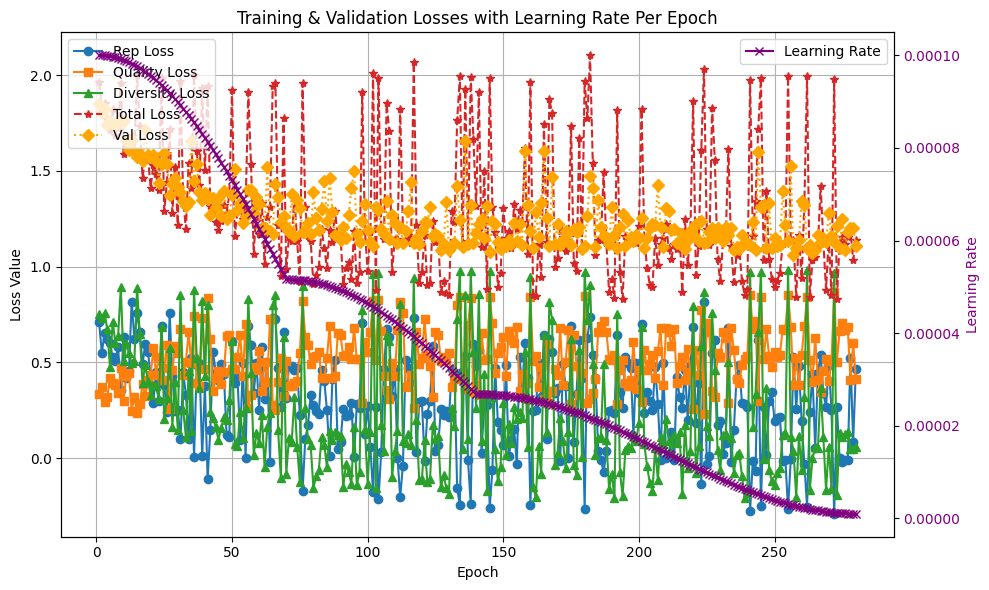

In [37]:
plot_training_logs(training_logs)